# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
from scipy import linalg

In [2]:
PATH_TO_DATA = "C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        print("Nearest neighbors of \"%s\":" % w)
        scores = []
        indices = []
        for v in self.word2id.keys():
            scores.append(self.score(w,v))
            indices.append(v)# K most similar words: self.score  -  np.argsort 
        scores_sorted = np.argsort(scores)
        most_sim = []
        
        for i in range(K):
            most_sim.append(indices[scores_sorted[-i-1]])
        return most_sim

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        cos = np.dot(self.word2vec[w1],self.word2vec[w2]) /(np.linalg.norm(self.word2vec[w1])*np.linalg.norm(self.word2vec[w2]))
        #with self.word2vec[w1] the word embedding of w1 and self.word2vec[w2] the word embedding of w2
        return cos 


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=250000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
Nearest neighbors of "cat":
['cat', 'cats', 'kitty', 'kitten', 'feline']
Nearest neighbors of "dog":
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
Nearest neighbors of "dogs":
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
Nearest neighbors of "paris":
['paris', 'france', 'Paris', 'parisian', 'london']
Nearest neighbors of "germany":
['germany', 'austria', 'europe', 'german', 'berlin']


In [7]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # The first is a simple combination, where each sentence is represented by the average of the word embedding vectors of the words that compose the sentence.
        # The second approach also averages the word embedding vectors, but each embedding vector is now weighted (multiplied) by the tf-idf of the word it represents.
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                mean_word_embedding=np.zeros(300)
                len_sent=0
                for w in sent.split():
                    try :
                        mean_word_embedding = mean_word_embedding + self.w2v.word2vec[w]
                        len_sent = len_sent + 1
                    except :
                        continue
                mean_word_embedding=mean_word_embedding/len_sent
                sentemb.append(mean_word_embedding)
                #assert False
            else:
                idf_word_embedding=np.zeros(300)
                len_sent=0
                #idf-weighted mean of word vectors
                for w in sent.split():
                    try :
                        idf_word_embedding = idf_word_embedding + self.w2v.word2vec[w]*idf[w]
                        len_sent=len_sent+idf[w]
                    except :
                        continue
                idf_word_embedding=idf_word_embedding/len_sent
                sentemb.append(idf_word_embedding)
                #assert False
        return np.vstack(sentemb)    
    

    def most_similar(self, s, sentences, idf=False, K=5):
        scores = []
        indices = []
        for sent in sentences :
            scores.append(self.score(s,sent,idf))
            indices.append(sent)# K most similar words: self.score  -  np.argsort 
        scores = np.array(scores)
        scores_sorted = np.argsort(scores)
        most_sim = []
        for i in scores_sorted[scores_sorted.shape[0]-6:-1]:
            most_sim.append(indices[i])
        return most_sim
    
    
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_emb = self.encode([s1],idf).reshape(300)
        s2_emb = self.encode([s2],idf).reshape(300)
        cos = np.dot(s1_emb,s2_emb) /(np.linalg.norm(s1_emb)*np.linalg.norm(s2_emb))
        return cos
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                 idf[w] = idf.get(w, 0) + 1
        for word, val in idf.items() :
            idf[word]= max(1,np.log10(len(sentences) / (val)))
        return idf
        


In [6]:
# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/sentences.txt").read().split("\n")


In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/sentences.txt").read().split("\n")


# Build idf scores for each word
idf = s2v.build_idf(sentences)# if True else 

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


  
print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 50000 pretrained word vectors


C:\Users\david\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


['an afican american woman standing behind two small african american children . ', 'an african american in sunglasses and a white tee-shirt smiles . ', 'a little african american boy and girl looking up . ', 'an african american man smiling . ', '1 smiling african american boy . ']
0.5726258859719607
['an afican american woman standing behind two small african american children . ', 'a little african american boy and girl looking up . ', 'an african american man is sitting . ', 'an african american man smiling . ', '1 smiling african american boy . ']
0.47514504853169526


C:\Users\david\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [8]:
# 1 - Download and load 50k first vectors of
  #https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
  #https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
Eng = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
Fra = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)



Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [9]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

Eng_words = set(Eng.word2id.keys())
Fra_words = set(Fra.word2id.keys())
bilingual_dictionary=Eng_words.intersection(Fra_words)


X = []
Y = []
for word in bilingual_dictionary :
    X.append(Fra.word2vec[word])
    Y.append(Eng.word2vec[word])
X=np.asarray(X).T
Y=np.asarray(Y).T

In [10]:
X.shape

(300, 18970)

In [11]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U,sigma,Vt = linalg.svd(np.dot(Y,X.T))
W = np.dot(U,Vt)

In [12]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
Eng_dictionary = {}
Fra_dictionary = {}
for word in bilingual_dictionary :
    Eng_dictionary[word] = Eng.word2vec[word]

    Fra_dictionary[word] = Fra.word2vec[word]



In [13]:
i=0
new_space = (np.dot(W,X)).T
for word in Fra_dictionary.keys():
    Fra_dictionary[word] = new_space[i]
    i=i+1

In [14]:
def score(word_french,word_english):
    word_french= np.dot(W,Fra.word2vec[word_french]) #word french embedding in english space
    word_english= Eng.word2vec[word_english] # word english embedding
    cosine_similarity = (np.dot(word_french,word_english))/(np.linalg.norm(word_french)*np.linalg.norm(word_english))
    return cosine_similarity

def most_similar_fra2eng(w_french, K=5):
    # K most similar words: self.score  -  np.argsort 
    similarity_vector=[]
    words=[]
    for w_english in Eng.word2vec.keys(): 
        similarity_vector.append(score(w_french,w_english))
        words.append(w_english)
    similarity_vector = np.array(similarity_vector)
    sorted_similarity=np.argsort(similarity_vector) #indice sorted
    k_most_similar=[]
    for i in sorted_similarity[sorted_similarity.shape[0]-6:-1]: #-1 pour pas que lui meme apparait dans les plus similaires
        k_most_similar.append(words[i])
    return k_most_similar


def most_similar_eng2fra(w_english, K=5):
    # K most similar words: self.score  -  np.argsort 
    similarity_vector=[]
    words=[]
    for w_french in Fra.word2vec.keys(): 
        similarity_vector.append(score(w_french,w_english))
        words.append(w_french)
    similarity_vector = np.array(similarity_vector)
    sorted_similarity=np.argsort(similarity_vector) #indice sorted
    k_most_similar=[]
    for i in sorted_similarity[sorted_similarity.shape[0]-6:-1]: #-1 pour pas que lui meme apparait dans les plus similaires
        k_most_similar.append(words[i])
    return k_most_similar


In [15]:
test_french = ["lasse","actes","état","elle","cartilage"]
for words in test_french :
    print(most_similar_fra2eng(words))

['eriksson', 'hansson', 'erik', 'lars', 'anders']
['comédie', 'tableaux', 'libretto', 'comique', 'acts']
['legislature', 'etat', 'statehood', 'estado', 'état']
['herself', 'hers', 'claire', 'her', 'elle']
['femoral', 'tendon', 'ligament', 'ligaments', 'tendons']


In [16]:
test_english = ["chicken","dog","admirable","wifi","offensive"]
for words in test_english :
    print(most_similar_eng2fra(words))

['sauce', 'porc', 'pizza', 'dinde', 'poulet']
['chicken', 'chienne', 'chiens', 'hound', 'chien']
['plaisante', 'courage', 'irréprochable', 'incomparable', 'modestie']
['usb', 'téléphones', 'portables', 'gsm', 'bluetooth']
['defensive', 'offensifs', 'tackle', 'défensive', 'offensives']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [17]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

sentences_train=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.train").read().split("\n")
sentences_dev=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.dev").read().split("\n")
sentences_test=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.test.X").read().split("\n")

In [18]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Last sentence is "", hence we remove it
sentences_train = sentences_train[:-1]



#Extract the classification label in training set: 0/1/2/3/4
x_train=[]
y_train=[]
for sent in sentences_train:
        y_train.append(sent[0])
        x_train.append(sent[1:])

#Build idf
idf = s2v.build_idf(x_train)        
        
#Building X train for average of word vector and weighted average

X_train_AMW =s2v.encode(x_train,idf=False)
X_train_WA = s2v.encode(x_train,idf)







Loaded 200000 pretrained word vectors


In [19]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Last sentence is "", hence we remove it
sentences_dev = sentences_dev[:-1]

#Extract the classification label in dev set: 0/1/2/3/4  
x_dev=[]
y_dev=[]
for sent in sentences_dev:
        y_dev.append(sent[0])
        x_dev.append(sent[1:])
        
        
idf = s2v.build_idf(x_dev)

#Building X dev for average of word vector and weighted average

X_dev_AMW =s2v.encode(x_dev,idf=False)
X_dev_WA = s2v.encode(x_dev,idf)


Loaded 200000 pretrained word vectors


In [20]:
# Last sentence is "", hence we remove it
sentences_test = sentences_test[:-1]

idf = s2v.build_idf(sentences_test)
#Building X test for average of word vector and weighted average
X_test_AMW =s2v.encode(sentences_test,idf=False)
X_test_WA = s2v.encode(sentences_test,idf)


In [21]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Fit a logistic regression for Average of Word vector

logreg_AWV=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter= 10000,penalty="l2").fit(X_train_AMW,y_train)

print('Training score using the average of word vectors: {:.2f}'.format(logreg_AWV.score(X_train_AMW,y_train)))
print('Dev score using the average of word vectors: {:.2f}'.format(logreg_AWV.score(X_dev_AMW,y_dev)))

#print("tuned hpyerparameters :(best parameters) ",logreg_AWV.best_params_)
#print("accuracy :",logreg_AWV.best_score_)




Training score using the average of word vectors: 0.50
Dev score using the average of word vectors: 0.44


In [22]:
# Fit a logistic regression for Weighted Average

logreg_WA=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter = 10000).fit(X_train_WA,y_train)

print('Training score using the weighted average of vectors: {:.2f}'.format(logreg_WA.score(X_train_WA,y_train)))
print('Dev score using the weighted average of vectors : {:.2f}'.format(logreg_WA.score(X_dev_WA,y_dev)))


Training score using the weighted average of vectors: 0.50
Dev score using the weighted average of vectors : 0.42


In [23]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

#Predictions on test set for Average Word Vector

y_pred_AMW = logreg_AWV.predict(X_test_AMW)

with open("logreg_AWV_bov_y_test_sst.txt","w") as pred1:
    for row in y_pred_AMW:
        pred1.write(row)
        pred1.write('\n')

#Predictions on test set for Weighted Average
        
y_pred_WA = logreg_WA.predict(X_test_AMW)

with open("logreg_WA_bov_y_test_sst.txt","w") as pred1:
    for row in y_pred_WA:
        pred1.write(row)
        pred1.write('\n')

In [24]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

#XGboost classifier on Average Word vectors 
from xgboost import XGBClassifier

xgb_AWV=XGBClassifier()
xgb_AWV.fit(X_train_AMW, y_train)

print('Training score using the average of word vectors: {:.2f}'.format(xgb_AWV.score(X_train_AMW,y_train)))
print('Dev score using the average of word vectors: {:.2f}'.format(xgb_AWV.score(X_dev_AMW,y_dev)))

#Predictions on test set for Average Word Vector

y_pred_AMW = xgb_AWV.predict(X_test_AMW)

with open("XGboost_bov_y_test_sst.txt","w") as pred1:
    for row in y_pred_AMW:
        pred1.write(row)
        pred1.write('\n')

#XGboost classifier on Weighted Average     
        
xgb_WA=XGBClassifier()
xgb_WA.fit(X_train_AMW, y_train)

print('Training score using the average of word vectors: {:.2f}'.format(xgb_WA.score(X_train_WA,y_train)))
print('Dev score using the weighted average of vectorss: {:.2f}'.format(xgb_WA.score(X_dev_WA,y_dev)))
#Predictions on test set for Weighted Average
        
y_pred_WA = logreg_WA.predict(X_test_WA)

with open("XGboost_bov_y_test_sst.txt","w") as pred1:
    for row in y_pred_WA:
        pred1.write(row)
        pred1.write('\n')

Training score using the average of word vectors: 0.62
Dev score using the average of word vectors: 0.41
Training score using the average of word vectors: 0.52
Dev score using the weighted average of vectorss: 0.40


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [2]:
import keras

Using TensorFlow backend.


In [3]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST"

# TYPE CODE HERE
sentences_train=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.train").read().split("\n")
sentences_dev=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.dev").read().split("\n")
sentences_test=open("C:/Users/david/Desktop/Master in Data Science/Cours/Deep Learning/Exos/Assignment 2/nlp_project/data/SST/stsa.fine.test.X").read().split("\n")

In [4]:
# Removing last sentence which is empty ''
sentences_train = sentences_train[0:len(sentences_train)-1]
sentences_dev = sentences_dev[0:len(sentences_dev)-1]
sentences_test = sentences_test[0:len(sentences_test)-1]

#Define training set and class labels
x_train=[]
y_train=[]
for sent in sentences_train:
    y_train.append(sent[0])
    x_train.append(sent[1:])

y_train = keras.utils.to_categorical(y_train, num_classes=5)

#Define dev set and class labels
x_dev=[]
y_dev=[]
for sent in sentences_dev:
    y_dev.append(sent[0])
    x_dev.append(sent[1:])
    
y_dev = keras.utils.to_categorical(y_dev, num_classes=5)

#Define test set 
x_test = sentences_test

In [5]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

#Finding number of words in vocabulary : 
vocab = len(set([w for sent in (x_train+x_dev+x_test) for w in sent.split() ]))

#Tokenizing training sentences
l_train=[]
for i in range(len(x_train)):
    l_train.append(keras.preprocessing.text.one_hot(x_train[i], vocab, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' '))

#Tokenizing dev sentences
l_dev=[]
for i in range(len(x_dev)):
    l_dev.append(keras.preprocessing.text.one_hot(x_dev[i], vocab, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' '))


#Tokenizing test sentences
l_test=[]
for i in range(len(x_test)):
    l_test.append(keras.preprocessing.text.one_hot(x_test[i], 17839, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' '))


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [6]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

#Finding longest list in a list of lists
def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list

#Padding function
def padding(l):
    pad = keras.preprocessing.sequence.pad_sequences(l, maxlen=max(longest(l_train),longest(l_dev),longest(l_test)), dtype='int32', padding='pre', truncating='pre', value=0.0)
    return pad   

#Padding my lists
x_train_pad = padding(l_train)
x_dev_pad = padding(l_dev)
x_test_pad = padding(l_test)

## 4.2 - Design and train your model

In [7]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 256  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab  # size of the vocabulary
n_classes  = 5
length_max = longest(x_train_pad)

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = length_max))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [8]:
longest(x_train_pad)

52

In [9]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 256)           5001728   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 5,084,229
Trainable params: 5,084,229
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 6
history = model.fit(x_train_pad, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev_pad, y_dev))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 15s 2ms/step - loss: 1.5618 - acc: 0.2856 - val_loss: 1.5229 - val_acc: 0.3270
Epoch 2/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.3804 - acc: 0.3893 - val_loss: 1.4327 - val_acc: 0.3706
Epoch 3/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.1849 - acc: 0.4542 - val_loss: 1.3976 - val_acc: 0.3960
Epoch 4/6
8544/8544 [==============================] - 32s 4ms/step - loss: 1.0422 - acc: 0.5092 - val_loss: 1.4742 - val_acc: 0.3688
Epoch 5/6
8544/8544 [==============================] - 20s 2ms/step - loss: 0.9108 - acc: 0.5816 - val_loss: 1.5833 - val_acc: 0.3797
Epoch 6/6
8544/8544 [==============================] - 21s 3ms/step - loss: 0.7940 - acc: 0.6629 - val_loss: 1.7326 - val_acc: 0.3733


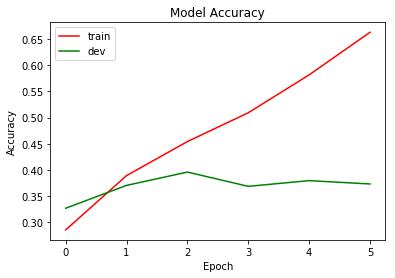

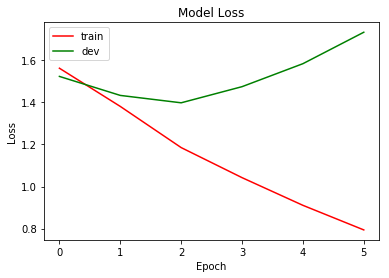

In [12]:
import matplotlib.pyplot as plt

# plot history for accuracy with respect to the number of epochs
plt.plot(history.history['acc'],color = 'red')
plt.plot(history.history['val_acc'], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# plot history for loss with respect to the number of epochs
plt.plot(history.history['loss'],color = 'red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [35]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

y_predict = model.predict(x_test_pad)
y_predict = np.argmax(y_predict, axis=1)
with open("logreg_lstm_y_test_sst.txt","w") as pred1:
    for row in y_predict:
        pred1.write(str(row))
        pred1.write('\n')
        



## 4.3 -- innovate !

In [94]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from keras.layers import Conv1D,Flatten,MaxPool1D,Dropout,BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.constraints import max_norm
early_stopping_monitor = EarlyStopping(patience=2)
model2 = Sequential()
model2.add(Embedding(vocab, 256, input_length = length_max))
model2.add(Dropout(0.3))
model2.add(Conv1D(250,kernel_size=3,activation ="relu"))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(5,activation = "softmax"))
model2.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy',metrics  =  ['accuracy'])
print(model2.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 52, 256)           5001728   
_________________________________________________________________
dropout_28 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 50, 250)           192250    
_________________________________________________________________
dropout_29 (Dropout)         (None, 50, 250)           0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 12500)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 62505     
Total params: 5,256,483
Trainable params: 5,256,483
Non-trainable params: 0
_________________________________________________________________


In [95]:
history2 = model2.fit(x_train_pad,y_train,epochs = 10,validation_data=(x_dev_pad, y_dev),batch_size = bs,callbacks=[early_stopping_monitor])

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 20s 2ms/step - loss: 1.5658 - acc: 0.2787 - val_loss: 1.5388 - val_acc: 0.3424
Epoch 2/10
8544/8544 [==============================] - 17s 2ms/step - loss: 1.3660 - acc: 0.4232 - val_loss: 1.4102 - val_acc: 0.3942
Epoch 3/10
8544/8544 [==============================] - 17s 2ms/step - loss: 1.0394 - acc: 0.5938 - val_loss: 1.4115 - val_acc: 0.3869
Epoch 4/10
8544/8544 [==============================] - 17s 2ms/step - loss: 0.7334 - acc: 0.7540 - val_loss: 1.5597 - val_acc: 0.3497


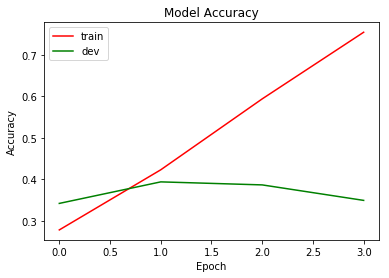

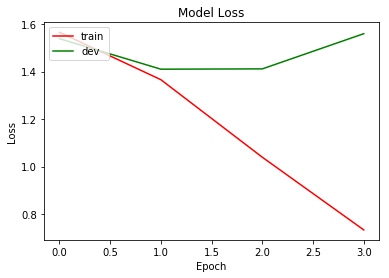

In [96]:
# plot history for accuracy with respect to the number of epochs
plt.plot(history2.history['acc'],color = 'red')
plt.plot(history2.history['val_acc'], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# plot history for loss with respect to the number of epochs
plt.plot(history2.history['loss'],color = 'red')
plt.plot(history2.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [97]:
y_predict2 = model2.predict(x_test_pad)
y_predict2 = np.argmax(y_predict2, axis=1)
with open("Convol_y_test_sst.txt","w") as pred1:
    for row in y_predict:
        pred1.write(str(row))
        pred1.write('\n')